In [66]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from sklearn.model_selection import train_test_split

# Homework 8 - Neural Networks 1


In [67]:
class LogisticRegressionGD:
    """
    Logistic Regression using Gradient Descent with Cross-Entropy Loss.

    :param learning_rate: The step size for each iteration.
    :param epochs: Number of iterations over the training data.
    :param verbose: If True, prints loss during training.
    """

    def __init__(self, learning_rate=0.01, epochs=1000, verbose=False):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.verbose = verbose
        self.W = None
        self.b = None

    def initialize_parameters(self, n_features, n_targets):
        """
        Initialize weights and bias with small random values.

        :param n_features: Number of input features.
        :param n_targets: Number of target outputs.
        """
        self.W = np.random.randn(n_features, n_targets) * 0.01
        self.b = np.zeros((1, n_targets))

    @staticmethod
    def softmax(z):
        """
        Compute the softmax of each row of the input array.
        Hint: Make sure to write a function that is numerically stable.
            - exp(z) is unstable for large values of z (can overflow to infinity)
            - exp(z) is unstable for small values of z (can underflow to zero)
            there are techniques to make it numerically stable.
        :param z: numpy.ndarray, input array.
        :returns: numpy.ndarray, softmax probabilities.
        """
        # <your_code>
        # ensure numerical stability
        z_stable = z - np.max(z, axis=1, keepdims=True) 
        softmax = np.exp(z_stable) / np.sum(np.exp(z_stable), axis=1, keepdims=True)
        # </your_code>
        return softmax

    def compute_loss(self, y_true, y_pred):
        """
        Compute Cross-Entropy loss.
        
        Feel free to google the formula for cross-entropy loss.
        Be mindful of the numerical stability of operations (e.g. log(0) is undefined).

        :param y_true: Actual target values (one-hot encoded).
        :param y_pred: Predicted probabilities.
        :returns: Cross-entropy loss value.
        """
        # <your_code>
        y_pred_stable = np.clip(y_pred, 1e-10, 1 - 1e-10) #  for numerical stability
        N = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred_stable))/N
        # </your_code>
        return loss

    def gradient_descent_step(self, X, y_true, y_pred):
        """
        Perform a single gradient descent step.

        :param X: Input feature matrix.
        :param y_true: Actual target values (one-hot encoded).
        :param y_pred: Predicted probabilities.
        :returns: Gradients with respect to W and b.
        
        """
        # <your_code>
        """
       ---Calculate gradients---
        L = -1/N * sum(y_true * log(y_pred))
        y_pred = exp(u)/sum(exp(u))
        u = Wx + b
        dL/du = dL/dy_pred * dy_pred/du
        dL/dy_pred = -1/N * y_true/y_pred
        dy_pred/du = y_pred * (1 - y_pred)
        dL/du = y_true - y_pred #with help of chatgpt


        ---calculate dL/dW---
        dL/dW = dL/du * du/dW
        du/dW = X
        dL/dW = (y_true - y_pred) * X

        ---calculate dL/db---
        dL/db = dL/du * du/db
        du/db = 1
        dL/db = sum(y_true - y_pred)/Nwyjaśni
        """

        N = X.shape[0] 
        dW = np.dot(X.T, (y_pred - y_true)) / N  
        db = np.sum(y_pred - y_true, axis=0, keepdims=True) / N 

        
        # </your_code>
        return dW, db

    def fit(self, X, y, X_val, y_val):
        """
        Train the logistic regression model using gradient descent.

        :param X: numpy.ndarray, feature values.
        :param y: numpy.ndarray, target values (one-hot encoded).
        :param X_val: numpy.ndarray, validation feature values.
        :param y_val: numpy.ndarray, validation target values (one-hot encoded).
        """
        n_features = X.shape[1]
        n_targets = y.shape[1]
        self.initialize_parameters(n_features, n_targets)
        train_losses = []
        val_losses = []

        for epoch in range(self.epochs):
            Z = np.dot(X, self.W) + self.b
            y_pred = self.softmax(Z)
            loss = self.compute_loss(y, y_pred)
            dW, db = self.gradient_descent_step(X, y, y_pred)

            self.W -= self.learning_rate * dW
            self.b -= self.learning_rate * db

            validation_loss = self.compute_loss(y_val, self.predict(X_val))
            train_losses.append(loss)
            val_losses.append(validation_loss)

        if self.verbose and epoch % 100 == 0:
            print(
                f"Epoch {epoch}, Training Loss: {loss}, Validation Loss: {validation_loss}"
            )
        plt.figure(figsize=(5, 3))
        plt.plot(train_losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.legend()
        plt.show()

    def predict(self, X):
        """
        Predict target probabilities using the trained model.

        :param X: numpy.ndarray, feature values.
        :returns: numpy.ndarray, predicted probabilities.
        """
        Z = np.dot(X, self.W) + self.b
        return self.softmax(Z)

In [68]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]


In [69]:
def preprocess_data():
    """
    Load and preprocess the CIFAR-10 dataset.

    :returns: Tuple of train and test datasets.
    """
    cifar = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
    X_train, y_train = cifar.data, cifar.targets
    cifar = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)
    X_test, y_test = cifar.data, cifar.targets

    # Normalize the data
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0

    # Flatten the images
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    num_classes = len(np.unique(y_train))
    y_train = one_hot_encode(y_train, num_classes)
    y_test = one_hot_encode(y_test, num_classes)

    return X_train, X_test, y_train, y_test


def visualize_weights(W):
    """
    Visualize the weight matrix as images.

    :param W: Weight matrix of shape (n_features, n_targets).
    """
    cifar_class_labels = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
    n_targets = W.shape[1]
    n_cols = 5
    n_rows = n_targets // n_cols + int(n_targets % n_cols != 0)

    plt.figure(figsize=(15, 3 * n_rows))
    for i in range(n_targets):
        plt.subplot(n_rows, n_cols, i + 1)
        # Reshape weights to image shape (32x32x3)
        weight_img = W[:, i].reshape(32, 32, 3)
        # Normalize for better visualization
        weight_img = (weight_img - weight_img.min()) / (
            weight_img.max() - weight_img.min()
        )
        plt.imshow(weight_img)
        plt.title(f"Class: {cifar_class_labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Files already downloaded and verified
Files already downloaded and verified
Using 20000 training samples and 2000 validation samples
Using 2000 test samples


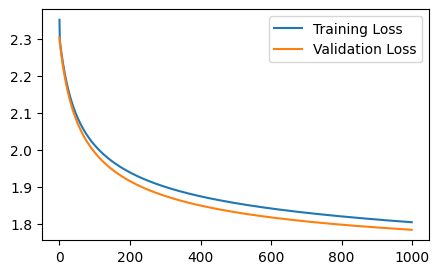

In [70]:
X_train, X_test, y_train, y_test = preprocess_data()

# To reduce computational load, use a subset of the data
X_train, _, y_train, _ = train_test_split(
    X_train, y_train, train_size=22000, random_state=42
)
X_validate, X_train, y_validate, y_train = train_test_split(
    X_train, y_train, train_size=2000, random_state=42
)
X_test, _, y_test, _ = train_test_split(
    X_test, y_test, train_size=2000, random_state=42
)

print(
    f"Using {X_train.shape[0]} training samples and {X_validate.shape[0]} validation samples"
)
print(f"Using {X_test.shape[0]} test samples")

model = LogisticRegressionGD(learning_rate=0.01, epochs=1000, verbose=True)
model.fit(X_train, y_train, X_validate, y_validate)


In [71]:
predictions = model.predict(X_test)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
test_loss = model.compute_loss(y_test, predictions)
print(f"Test Accuracy: {accuracy}")

print(f"Test Loss: {test_loss}")

Test Accuracy: 0.367
Test Loss: 1.8066826681651382


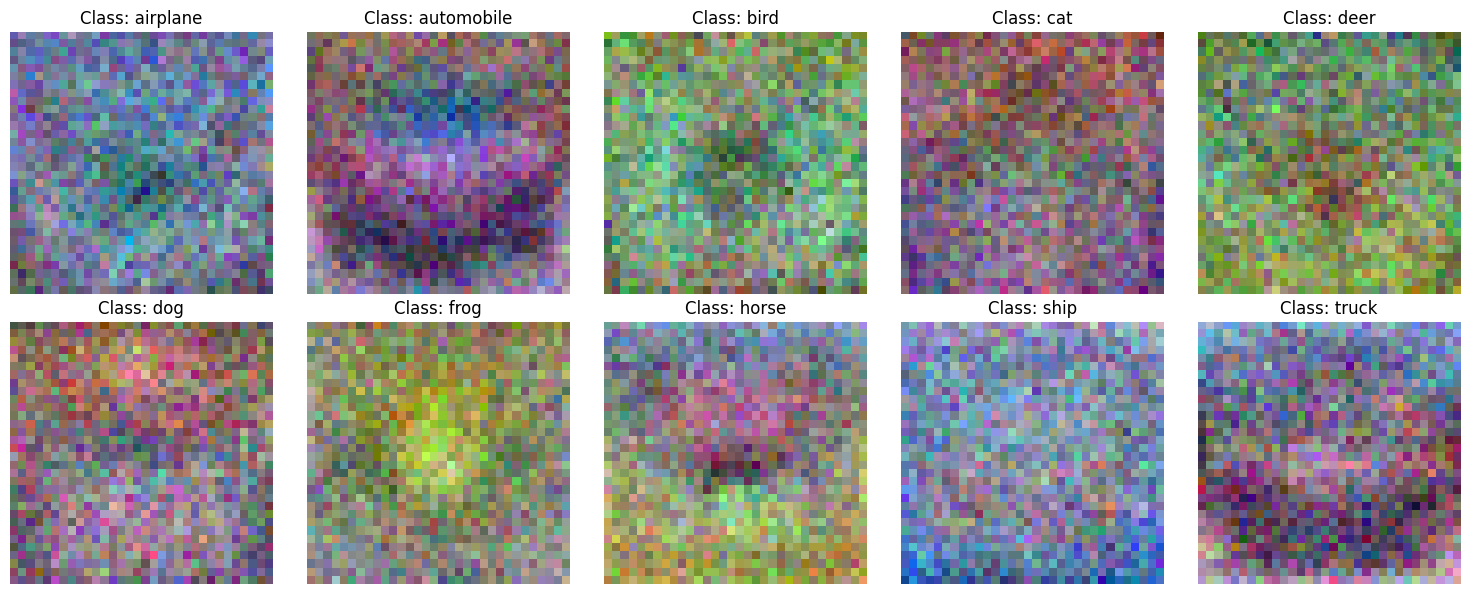

In [72]:
visualize_weights(model.W)